## Starting Spark

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)


24/06/28 00:20:15 WARN Utils: Your hostname, MacBook-Pro-Sunith.local resolves to a loopback address: 127.0.0.1; using 10.10.67.15 instead (on interface en0)
24/06/28 00:20:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/28 00:20:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Matplotlib is building the font cache; this may take a moment.


## Importing and Basic Cleaning

In [2]:
# import pandas as pd

file_path = '/Users/sunith/dss_project/data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# description_path = '/Users/sunith/dss_project/data/DescriptionDataCoSupplyChain.csv'
# df_description = spark.read.csv(description_path, header=True, inferSchema=True)
# df = pd.read_csv(file_path, encoding='latin1')
df.show()

24/06/28 00:20:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [3]:
# Some house cleaning where the the column names are standardized
import pyspark.sql.functions as F
for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))


In [4]:

df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_status', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)")    
df.createOrReplaceTempView("my_table")
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|  delivery_status|late_delivery_risk|category_id| category_name| customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|depar

In [5]:
df.dtypes

[('type', 'string'),
 ('days_for_shipping_(real)', 'int'),
 ('days_for_shipment_(scheduled)', 'int'),
 ('benefit_per_order', 'double'),
 ('sales_per_customer', 'double'),
 ('delivery_status', 'string'),
 ('late_delivery_risk', 'int'),
 ('category_id', 'int'),
 ('category_name', 'string'),
 ('customer_city', 'string'),
 ('customer_country', 'string'),
 ('customer_id', 'int'),
 ('customer_segment', 'string'),
 ('customer_state', 'string'),
 ('customer_zipcode', 'int'),
 ('department_id', 'int'),
 ('department_name', 'string'),
 ('market', 'string'),
 ('order_city', 'string'),
 ('order_country', 'string'),
 ('order_customer_id', 'int'),
 ('order_id', 'int'),
 ('order_item_cardprod_id', 'int'),
 ('order_item_discount', 'double'),
 ('order_item_discount_rate', 'double'),
 ('order_item_id', 'int'),
 ('order_item_product_price', 'double'),
 ('order_item_profit_ratio', 'double'),
 ('order_item_quantity', 'int'),
 ('sales', 'double'),
 ('order_item_total', 'double'),
 ('order_profit_per_order',

In [6]:
df.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+------------------+------------------+------------------+-------------+----------------+----------------+----------------+------------------+-----------------+------------------+---------------+------+--------------+-------------+-----------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+------------------+------------------+-------------------+--------------------+------------------+--------------+
|summary|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)| benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|       category_id|     category_name|customer_city|customer_country|     customer

## Data Exploration

Wanted to see if a customer appears multiple times in the dataset

In [8]:
spark.sql("Select customer_id From my_table GROUP BY customer_id having count(customer_id) > 1 limit 5").show()

+-----------+
|customer_id|
+-----------+
|       3997|
|       6466|
|        471|
|       6397|
|       5518|
+-----------+



In [9]:
df.filter(df.customer_id == 3997).show()

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------+-------------+--------------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+--------------------+------------+-------------+---------------+-------------------+--------------------+-------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id|       category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipc

We are trying to see if there are orders extending to multiple rows.

In [10]:
spark.sql("Select order_id From my_table GROUP BY order_id having count(order_id) > 1 limit 5").show()

+--------+
|order_id|
+--------+
|   55155|
|   67753|
|   29993|
|   23571|
|   37111|
+--------+



We can see that order is broken down into item level. Where each order can contain multiple items.

In [11]:
# We can see that there are multiple items in one order and they are in multiple rows
df.filter(df.order_id == 67753).show() 

+-----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+--------------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+--------------+-----------+------------+-------------+---------------+-------------------+--------------------+-------------+-------------+----------+-------------+
| type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|delivery_status|late_delivery_risk|category_id|       category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_

The columns that can be used for training an ML model.

In [8]:
# Pyspark distinct selection from a dataframe
df.select(df.late_delivery_risk).distinct().show()

+------------------+
|late_delivery_risk|
+------------------+
|                 1|
|                 0|
+------------------+



In [9]:
df.filter(df.order_country == 'EE. UU.').show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+------------+-------------+--------------------------+-------------+
|type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|delivery_status|late_delivery_risk|category_id|category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_name|m

Counts Based on categories for quick analysis

In [13]:
df.groupBy('delivery_status').count().orderBy('count', ascending=False).show()

+-----------------+-----+
|  delivery_status|count|
+-----------------+-----+
|    Late delivery|98977|
| Advance shipping|41592|
| Shipping on time|32196|
|Shipping canceled| 7754|
+-----------------+-----+



In [21]:
spark.sql("""
          Select customer_segment, 
          sum(sales) as sales, 
          sum(order_profit_per_order) as profit,
          count(distinct(customer_id)) as cust_count
          From my_table 
          GROUP BY customer_segment
          ORDER BY sales DESC
          """).show()

+----------------+--------------------+------------------+----------+
|customer_segment|               sales|            profit|cust_count|
+----------------+--------------------+------------------+----------+
|        Consumer|1.9095790155174054E7|2073487.6719135328|     10695|
|       Corporate|1.1168406842990492E7|1202574.9615065993|      6239|
|     Home Office|  6520538.0152156735| 690840.3406302303|      3718|
+----------------+--------------------+------------------+----------+



In [25]:
spark.sql("""
          Select shipping_mode, 
          sum(sales) as sales, 
          sum(order_profit_per_order) as profit,
          count(distinct(customer_id)) as cust_count
          From my_table 
          GROUP BY shipping_mode
          ORDER BY sales DESC
          """).show()

+--------------+--------------------+------------------+----------+
| shipping_mode|               sales|            profit|cust_count|
+--------------+--------------------+------------------+----------+
|Standard Class|2.2022391879808668E7|2370454.4528039624|     16578|
|  Second Class|   7145444.818358937| 750308.1702654322|      8969|
|   First Class|   5674369.758202563| 643121.9207390624|      7594|
|      Same Day|  1942528.5570090855|203018.43024189796|      3208|
+--------------+--------------------+------------------+----------+



In [16]:
df.groupBy('customer_segment').count().orderBy('count', ascending=False).show()

+----------------+-----+
|customer_segment|count|
+----------------+-----+
|        Consumer|93504|
|       Corporate|54789|
|     Home Office|32226|
+----------------+-----+



In [19]:
df1 = df.groupBy('order_status').count().orderBy('count', ascending=False).toPandas()
df1

,order_status,count
0,COMPLETE,59491
1,PENDING_PAYMENT,39832
2,PROCESSING,21902
3,PENDING,20227
4,CLOSED,19616
5,ON_HOLD,9804
6,SUSPECTED_FRAUD,4062
7,CANCELED,3692
8,PAYMENT_REVIEW,1893


Text(0.5, 1.0, 'Order Status')

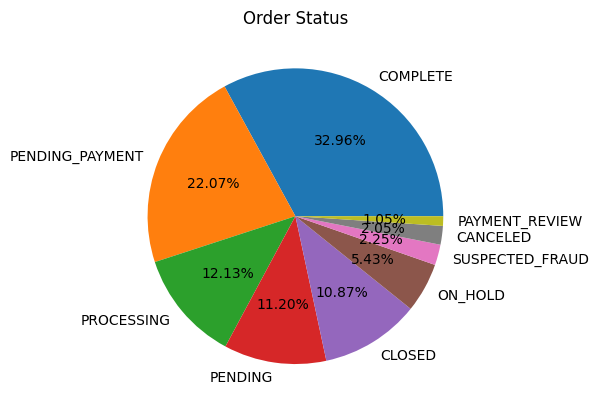

In [21]:
label=["COMPLETE","PENDING_PAYMENT","PROCESSING","PENDING","CLOSED","ON_HOLD","SUSPECTED_FRAUD","CANCELED","PAYMENT_REVIEW"]
plt.pie(df1['count'],labels=label, autopct='%1.2f%%')
plt.title("Order Status")

In [11]:
df.groupBy('order_country').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|       order_country|count|
+--------------------+-----+
|      Estados Unidos|24840|
|             Francia|13222|
|              M�xico|13172|
|            Alemania| 9564|
|           Australia| 8497|
|              Brasil| 7987|
|         Reino Unido| 7302|
|               China| 5758|
|              Italia| 4989|
|               India| 4783|
|           Indonesia| 4204|
|              Espa�a| 3868|
|         El Salvador| 3726|
|Rep�blica Dominicana| 3669|
|            Honduras| 3629|
|                Cuba| 3534|
|             Turqu�a| 3395|
|           Nicaragua| 3046|
|           Guatemala| 2778|
|             Nigeria| 2309|
+--------------------+-----+
only showing top 20 rows



In [12]:
spark.sql("SELECT order_status, count(order_status) as count From my_table group by order_status").show()

+---------------+-----+
|   order_status|count|
+---------------+-----+
|PENDING_PAYMENT|39832|
|       COMPLETE|59491|
|        ON_HOLD| 9804|
| PAYMENT_REVIEW| 1893|
|     PROCESSING|21902|
|         CLOSED|19616|
|SUSPECTED_FRAUD| 4062|
|        PENDING|20227|
|       CANCELED| 3692|
+---------------+-----+



## Data Modelling

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [22]:
df.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_nam

In [23]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="type", outputCol="payment_type") 
indexed = indexer.fit(df).transform(df) 
indexed.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+----------+-------------+------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|  delivery_status|late_delivery_risk|category_id| category_name| customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|depart